# **Clustering Analysis of Railway Delay Incidents**



> This notebook shows a comprehensive exploratory and analytical workflow for clustering railway delay incidents in the Airport Rail Link (ARL) system in Bangkok, Thailand.
The objective is to identify meaningful station-level patterns by jointly analyzing passenger demand and incident characteristics using unsupervised learning techniques.




## *Data Sources*
Passenger volume data and incident records were obtained from  
**Department of Rail Transport (DRT), Thailand**

- Passenger volumes:  
  https://drt.gdcatalog.go.th/dataset/drt2566_02

- Incident records:  
  https://drt.gdcatalog.go.th/dataset/drt2565_06


## *Acknowledgement*
We gratefully acknowledge the Department of Rail Transport (DRT), Thailand  
for making the datasets publicly available as open government data.

## **Load Libraries**

> This section imports all required Python libraries used for data manipulation, visualization, distance computation for mixed-type data, and clustering algorithms.



In [1]:
# Install required packages
# Uncomment when running in a fresh environment

!pip install gower
!pip install kmodes
!pip install scikit-learn-extra


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 12.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.3.0-cp312-cp312-linux_x86_64.whl size=1963618 sha256=7c9ca216c32c6dc3125f92d236e6414e8a73df160aede9a069e388d9321c594f
  Stored in directory: /root/.cache/pip/wheels/17/4d/c3/c6d5d563c1bf8146d059d63be3678abc2f2801fba0aaf5f0b8
Successfully built scikit-learn-extra


In [2]:
# --- Standard library ---
from datetime import datetime
import re
import sys
import unicodedata
import warnings

# --- Third-party libraries ---
import gower
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# --- SciPy ---
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.spatial.distance import pdist

# --- scikit-learn ---
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# --- kmodes ---
from kmodes.kprototypes import KPrototypes


In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme(style="whitegrid")

## **Load Data**



> Passenger demand data and incident records obtained from open government sources are loaded into the environment.
The two datasets are inspected to verify structure, data types, and basic integrity.



In [4]:
try:
    if "google.colab" in sys.modules:
        passenger_arl = pd.read_csv('/content/drive/MyDrive/WORK/2025_IEEE_Bigdata/2025_IEEE_Bigdata/passenger_arl.csv')
        incident_data = pd.read_csv('/content/drive/MyDrive/WORK/2025_IEEE_Bigdata/2025_IEEE_Bigdata/incident_data.csv')
    else:
        passenger_arl = pd.read_csv('data/passenger_arl.csv')
        incident_data = pd.read_csv('data/incident_data.csv')

except FileNotFoundError as e:
    print("ERROR: Dataset not found. Please check file paths.")
    raise e


## **Exploratory Data Analysis (Passenger Data)**


> This section explores daily passenger arrivals and departures at each station.



In [5]:
# ==================================
# Passenger Data: Basic Overview
# ==================================

print("Dataset shape:", passenger_arl.shape)
print("\nData types:")
display(passenger_arl.dtypes)

print("\nDataset info:")
passenger_arl.info()


Dataset shape: (9240, 8)

Data types:


,0
No.,int64
Type,object
Line,object
Station_Code,object
Station_Name,object
Passenger_Arrival,int64
Passenger_Departure,int64
Date,object



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   No.                  9240 non-null   int64 
 1   Type                 9240 non-null   object
 2   Line                 9240 non-null   object
 3   Station_Code         9240 non-null   object
 4   Station_Name         9240 non-null   object
 5   Passenger_Arrival    9240 non-null   int64 
 6   Passenger_Departure  9240 non-null   int64 
 7   Date                 9240 non-null   object
dtypes: int64(3), object(5)
memory usage: 577.6+ KB


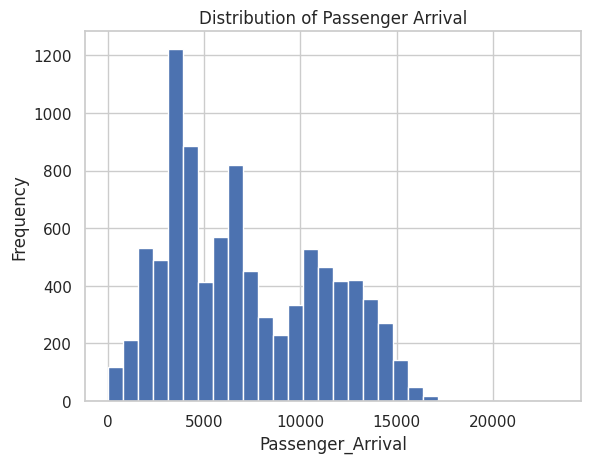

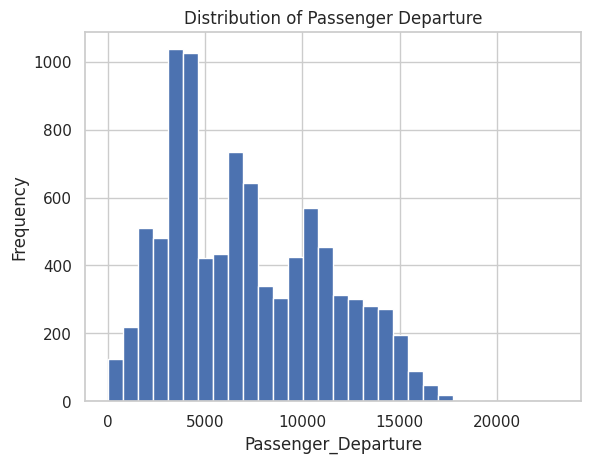

In [6]:
# กลุ่ม demand ต่าง ๆ เกิดจากอะไร?
# เวลา? สถานี? holiday? สาเหตุ? interchange?

# Passenger Arrival Distribution
passenger_arl['Passenger_Arrival'].hist(bins=30)
plt.title("Distribution of Passenger Arrival")
plt.xlabel("Passenger_Arrival")
plt.ylabel("Frequency")
plt.show()

# Passenger Departure Distribution
passenger_arl['Passenger_Departure'].hist(bins=30)
plt.title("Distribution of Passenger Departure")
plt.xlabel("Passenger_Departure")
plt.ylabel("Frequency")
plt.show()


In [7]:
# ==================================
# Check simultaneous zero values
# ==================================

passenger_arl['both_zero'] = (
    (passenger_arl['Passenger_Arrival'] == 0) &
    (passenger_arl['Passenger_Departure'] == 0)
)

print("Number of records with both Arrival and Departure = 0:",
      passenger_arl['both_zero'].sum())


Number of records with both Arrival and Departure = 0: 112


## **Exploratory Data Analysis (Incident Data)**


In [8]:
# ==================================
# Incident Data: Basic Overview
# ==================================

print("Dataset shape:", incident_data.shape)

print("\nData types:")
display(incident_data.dtypes)

print("\nDataset info:")
incident_data.info()


Dataset shape: (978, 14)

Data types:


,0
ID,float64
YEAR,float64
MONTH,object
DATE,object
TIME,object
TRAIN_ID,object
LINE_ID,float64
PLACE_ID,float64
ST1_ID,object
ST2_ID,object



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        707 non-null    float64
 1   YEAR      708 non-null    float64
 2   MONTH     708 non-null    object 
 3   DATE      708 non-null    object 
 4   TIME      704 non-null    object 
 5   TRAIN_ID  472 non-null    object 
 6   LINE_ID   708 non-null    float64
 7   PLACE_ID  686 non-null    float64
 8   ST1_ID    684 non-null    object 
 9   ST2_ID    200 non-null    object 
 10  DELAY_ID  707 non-null    object 
 11  OPERATOR  708 non-null    object 
 12  CAUSE_ID  708 non-null    float64
 13  DETAIL    708 non-null    object 
dtypes: float64(5), object(9)
memory usage: 107.1+ KB


In [9]:
print("Dataset shape:", incident_data.shape)
print("\nMissing values per column:")
display(incident_data.isna().sum())


Dataset shape: (978, 14)

Missing values per column:


,0
ID,271
YEAR,270
MONTH,270
DATE,270
TIME,274
TRAIN_ID,506
LINE_ID,270
PLACE_ID,292
ST1_ID,294
ST2_ID,778


## **Data Cleaning**



> Raw data is cleaned and standardized to ensure reliability of subsequent analysis.




```
- Before Merge (1) Passenger Data
- Before Merge (2) Incident Data
```




In [10]:
def clean_arl_data(
    df,
    drop_constant_cols=True,
    drop_unused_cols=True,
    date_range=None,
    impute_zero_as_missing=False,
    impute_cols=("Passenger_Arrival", "Passenger_Departure"),
    station_col="Station_Code",
    impute_method="median",
    convert_dtypes=True,
    category_cols=("Type", "Line"),
):
    """
    ฟังก์ชันทำความสะอาดข้อมูล ARL แบบเบื้องต้น

    พารามิเตอร์หลัก:
    - drop_constant_cols     : ลบคอลัมน์ที่มีค่าเดียวทั้งคอลัมน์
    - drop_unused_cols       : ลบคอลัมน์ที่ไม่ใช้ (เช่น No., Station_Name)
    - date_range             : กรองช่วงวันที่ (tuple/list: [start_date, end_date])
    - impute_zero_as_missing : ให้ตีความค่า 0 ใน impute_cols เป็น missing แล้วเติมค่า
    - impute_cols            : คอลัมน์ตัวเลขที่ใช้ impute (default: Passenger_Arrival/Departure)
    - station_col            : คอลัมน์สถานี ใช้ group ในการ impute ตามสถานี
    - impute_method          : วิธีเติมค่า เช่น 'median', 'mean'
    - convert_dtypes         : ให้ช่วยแปลงชนิดข้อมูลที่พบบ่อย (datetime/category/numeric)
    - category_cols          : คอลัมน์ที่อยากแปลงเป็น category ถ้ามีใน df
    """
    df = df.copy()

    # ----- จัดการวันที่และช่วงวันที่ -----
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
        if date_range is not None:
            start_date, end_date = pd.to_datetime(date_range[0]), pd.to_datetime(
                date_range[1]
            )
            df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]

    # ----- ลบคอลัมน์ที่ค่าเหมือนกันทั้งคอลัมน์ -----
    if drop_constant_cols:
        constant_cols = df.columns[df.nunique(dropna=False) == 1].tolist()
        df = df.drop(columns=constant_cols, errors="ignore")

    # ----- ลบคอลัมน์ที่ไม่ได้ใช้ -----
    if drop_unused_cols:
        unused_cols = ["No.", "Station_Name"]
        df = df.drop(
            columns=[c for c in unused_cols if c in df.columns],
            errors="ignore",
        )

    # ----- แปลงชนิดข้อมูลเพิ่มเติม (optional) -----
    if convert_dtypes:
        # แปลงคอลัมน์หมวดหมู่
        for c in category_cols:
            if c in df.columns:
                df[c] = df[c].astype("category")

        # แปลงคอลัมน์ตัวเลขพื้นฐานที่มักใช้
        numeric_candidates = ["Passenger_Arrival", "Passenger_Departure", "No."]
        for c in numeric_candidates:
            if c in df.columns:
                df[c] = pd.to_numeric(df[c], errors="coerce")

        # station_col ให้เป็น string (ไว้ใช้ group และ clean ได้ง่าย)
        if station_col in df.columns:
            df[station_col] = (
                df[station_col].astype(str).str.strip().str.upper()
            )

    # ====== ส่วน impute ค่า 0 เป็น missing แล้วเติม ======
    if impute_zero_as_missing:
        has_station = station_col in df.columns

        use_cols = [c for c in impute_cols if c in df.columns]
        for c in use_cols:
            # แปลงเป็นตัวเลขและตีความ 0 เป็น missing
            df[c] = pd.to_numeric(df[c], errors="coerce")
            df.loc[df[c] == 0, c] = np.nan

            # ถ้ามี station_col ให้เติมตามกลุ่มสถานีก่อน
            if has_station:
                grp_stat = df.groupby(
                    station_col,
                    dropna=False,
                )[c].transform(impute_method)
                df[c] = df[c].fillna(grp_stat)

            # เติมสำรองด้วยสถิติทั้งคอลัมน์ (median/mean/ฯลฯ)
            overall = getattr(df[c], impute_method)()
            if pd.notna(overall):
                df[c] = df[c].fillna(overall)

    return df


passenger_arl = clean_arl_data(
    passenger_arl,
    date_range=("2022-01-01", "2024-12-31"),
    impute_zero_as_missing=True,
    impute_cols=("Passenger_Arrival", "Passenger_Departure"),
    impute_method="median",
)


In [11]:
## Before Merge - Incident Data

import re
import unicodedata

# ---------------- Mapping สาเหตุ ----------------
CAUSE_MAPPING = {
    1:  "Train Propulsion System",
    2:  "Braking System",
    3:  "Door System",
    4:  "Power Supply System",
    5:  "Trackside Equipment",
    6:  "Rail Switch",
    7:  "Axle Counter System",
    8:  "Signaling and Control System",
    9:  "Foreign Objects",
    10: "Other Causes",
    11: "Passengers",
    12: "Automatic Train Protection (ATP)",
}


# ---------------- Helper: แปลง detail -> cause ----------------
def _infer_cause_from_detail(text):
    t = str(text).lower()

    if re.search(r'เบรค|เบรก|brake', t):
        return 2
    if re.search(r'ประตู|door', t):
        return 3
    if re.search(r'ขับเคลื่อน|มอเตอร์|propulsion', t):
        return 1
    if re.search(r'จ่ายไฟ|ไฟฟ้า|power supply', t):
        return 4
    if re.search(r'เขตราง|trackside', t):
        return 5
    if re.search(r'สับราง|switch', t):
        return 6
    if re.search(r'นับเพลา|axle', t):
        return 7
    if re.search(r'อาณัติสัญญาณ|สัญญาณ|ควบคุม|signaling|signal|control', t):
        return 8
    if re.search(r'แปลกปลอม|foreign|object', t):
        return 9
    if re.search(r'ผู้โดยสาร|passenger', t):
        return 11
    if re.search(r'\batp\b', t):
        return 12

    return 10


# ---------------- Helper: แปลง TIME ----------------
def _normalize_time_from_TIME(x):
    """
    รองรับ TIME หลายรูปแบบ:
      - 6, '6', '06'        -> 06:00
      - '22.1', 22.1        -> 22:10   (ทศนิยม 1 หลัก = หลักทศนิยม*10 นาที)
      - '7.04', 7.04        -> 07:04   (ทศนิยม 2 หลัก = นาทีสองหลัก)
      - '0.13'              -> 00:13
      - '15:25'             -> 15:25

    คืนค่าเป็น 'HH:MM' หรือ NaN
    """
    if pd.isna(x):
        return np.nan

    s = str(x).strip()

    # กรณี HH:MM
    m = re.fullmatch(r'([0-2]?\d):([0-5]\d)', s)
    if m:
        h, mm = int(m.group(1)), m.group(2)
        return f"{h:02d}:{mm}" if 0 <= h <= 23 else np.nan

    # กรณี H.MM / HH.MM
    m = re.fullmatch(r'(\d{1,2})\.(\d{1,2})', s)
    if m:
        h = int(m.group(1))
        frac = m.group(2)
        if 0 <= h <= 23:
            mm = int(frac) * 10 if len(frac) == 1 else int(frac)
            return f"{h:02d}:{mm:02d}" if 0 <= mm <= 59 else np.nan
        return np.nan

    # ชั่วโมงล้วน
    if re.fullmatch(r'\d{1,2}', s):
        h = int(s)
        return f"{h:02d}:00" if 0 <= h <= 23 else np.nan

    # float เช่น 6.0, 22.1
    try:
        f = float(s)
        h = int(f)
        if 0 <= h <= 23:
            f_str = f"{f}"
            frac_str = f_str.split(".")[1] if "." in f_str else ""
            if not frac_str:
                return f"{h:02d}:00"
            mm = int(frac_str) * 10 if len(frac_str) == 1 else int(frac_str[:2])
            return f"{h:02d}:{mm:02d}" if 0 <= mm <= 59 else np.nan
    except Exception:
        pass

    return np.nan


# ---------------- Helper: ดึงเวลา HH:MM จาก DETAIL ----------------
THAI_DIGITS = str.maketrans("๐๑๒๓๔๕๖๗๘๙", "0123456789")


def _extract_hhmm_from_detail(text):
    """
    ดึง 'เวลาแรก' ในข้อความเป็น HH:MM
    รองรับ 17.32 -> 17:32, 17:32, เลขไทย, full-width colon
    """
    if pd.isna(text):
        return np.nan

    t = str(text)

    # ล้างอักขระล่องหน แล้ว normalize
    t = (
        t.replace("\u200b", "")
        .replace("\ufeff", "")
        .replace("\xa0", " ")
    )
    t = unicodedata.normalize("NFKC", t)
    t = t.translate(THAI_DIGITS)

    # แปลง H.MM -> H:MM เฉพาะจุดหน้าสองหลัก
    t = re.sub(r"(?<=\d)[\.\uFF0E](?=\d{2})", ":", t)

    # หา H:MM หรือ HH:MM
    m = re.search(r"(?:^|[^0-9])((?:[01]?\d|2[0-3])[:：][0-5]\d)", t)
    return m.group(1).replace("：", ":") if m else np.nan


# ---------------- ฟังก์ชันหลัก: clean_incident_data ----------------
def clean_incident_data(
    df,
    drop_constant_cols=True,
    drop_unused_cols=True,
    date_range=None,
    fix_swapped_cols=True,
    fix_time_from_detail=True,
    time_col="TIME",
    detail_col="DETAIL",
    overwrite_time=False,
):
    df = df.copy()

    # แทนช่องว่างล้วนเป็น NaN + ลบคอลัมน์ Unnamed
    df = df.replace(r"^\s*$", np.nan, regex=True)
    df = df.loc[:, ~df.columns.str.contains(r"^Unnamed", case=False)]

    # แก้ ST1_ID ผิด
    if "ST1_ID" in df.columns:
        df.loc[df["ST1_ID"] == "YL12", "ST1_ID"] = "A1"

    # แปลง DATE และ filter ช่วงวันที่
    if "DATE" in df.columns:
        df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
        df = df.dropna(subset=["DATE"])

        if date_range is not None:
            start_date, end_date = map(pd.to_datetime, date_range)
            df = df[(df["DATE"] >= start_date) & (df["DATE"] <= end_date)]

    # Filter เฉพาะ LINE_ID=4, PLACE_ID=1, ST1_ID not null ถ้าคอลัมน์ครบ
    for col in ["LINE_ID", "PLACE_ID", "ST1_ID"]:
        if col not in df.columns:
            break
    else:
        df = df[
            (df["LINE_ID"] == 4)
            & (df["PLACE_ID"] == 1)
            & (df["ST1_ID"].notna())
        ]

    # ลบคอลัมน์ที่ไม่ใช้
    if drop_unused_cols:
        cols_to_remove = ["ID", "TRAIN_ID", "LINE_ID", "ST2_ID"]
        df = df.drop(
            columns=[c for c in cols_to_remove if c in df.columns],
            errors="ignore",
        )

    # sort index
    sort_cols = [c for c in ["DATE", "ST1_ID"] if c in df.columns]
    if sort_cols:
        df = df.sort_values(sort_cols).reset_index(drop=True)

    # Normalize ST1_ID
    if "ST1_ID" in df.columns:
        df["ST1_ID"] = (
            df["ST1_ID"].astype(str)
            .str.strip()
            .str.upper()
            .str.normalize("NFKC")
        )

    # ตรวจและสลับ CAUSE_ID / DELAY_ID ถ้าดูเหมือนใส่สลับกัน
    if fix_swapped_cols and {"CAUSE_ID", "DELAY_ID"}.issubset(df.columns):
        cause_vals = (
            df["CAUSE_ID"]
            .dropna()
            .astype(str)
            .str.upper()
            .str.strip()
        )
        cause_looks_delay = cause_vals.isin(["A", "B", "C", "O"]).mean() > 0.8
        delay_is_1_12 = (
            pd.to_numeric(df["DELAY_ID"], errors="coerce")
            .between(1, 12)
            .mean()
            > 0.8
        )

        if cause_looks_delay and delay_is_1_12:
            tmp = df["CAUSE_ID"].copy()
            df["CAUSE_ID"] = df["DELAY_ID"]
            df["DELAY_ID"] = tmp

    # Fix เวลา: TIME_main + เวลาใน DETAIL
    if fix_time_from_detail and (time_col in df.columns) and (detail_col in df.columns):
        df["TIME_raw"] = df[time_col]
        df["TIME_main_norm"] = df[time_col].apply(_normalize_time_from_TIME)
        df["TIME_detail_norm"] = df[detail_col].apply(_extract_hhmm_from_detail)

        df["TIME_final"] = np.where(
            df["TIME_detail_norm"].notna(),
            df["TIME_detail_norm"],
            df["TIME_main_norm"],
        )

        df["TIME_mismatch_flag"] = (
            df["TIME_detail_norm"].notna()
            & (df["TIME_main_norm"] != df["TIME_detail_norm"])
        )

        df["TIME_source"] = np.where(
            df["TIME_detail_norm"].notna(),
            "detail",
            np.where(df["TIME_main_norm"].notna(), "main", "unknown"),
        )

        if overwrite_time:
            df[time_col] = df["TIME_final"]

    # สร้าง CAUSE_ID_num
    if "CAUSE_ID" in df.columns:
        df["CAUSE_ID_num"] = (
            df["CAUSE_ID"]
            .astype(str)
            .str.strip()
            .str.extract(r"(\d+)")[0]
            .astype("Int64")
        )
    else:
        df["CAUSE_ID_num"] = pd.Series(
            pd.array([pd.NA] * len(df), dtype="Int64"),
            index=df.index,
        )

    # infer cause จาก DETAIL ถ้า CAUSE_ID_num ว่าง
    if "DETAIL" in df.columns:
        need_infer = df["CAUSE_ID_num"].isna()
        if need_infer.any():
            df.loc[need_infer, "CAUSE_ID_num"] = (
                df.loc[need_infer, "DETAIL"]
                .apply(_infer_cause_from_detail)
                .astype("Int64")
            )

    # mapping กรณีพิเศษกับ DELAY_ID
    if {"DELAY_ID", "CAUSE_ID_num"}.issubset(df.columns):
        di = df["DELAY_ID"].astype(str).str.upper()
        df.loc[(df["CAUSE_ID_num"] == 13) & (di == "B"), "CAUSE_ID_num"] = 2
        df.loc[(df["CAUSE_ID_num"] == 13) & (di == "C"), "CAUSE_ID_num"] = 12

    # map ชื่อ CAUSE_NAME
    df["CAUSE_NAME"] = df["CAUSE_ID_num"].map(CAUSE_MAPPING).fillna("UNKNOWN")

    # ลบ row ที่ทั้งแถวเป็น NaN
    all_nan_rows = df.isna().all(axis=1)
    if all_nan_rows.any():
        df = df.loc[~all_nan_rows].copy()

    # ลบคอลัมน์ที่เป็น NaN ทั้งคอลัมน์
    df = df.dropna(axis=1, how="all")

    # ลบคอลัมน์ที่ค่าเหมือนกันทั้งคอลัมน์
    if drop_constant_cols:
        const_cols = df.columns[df.nunique(dropna=False) == 1].tolist()
        df = df.drop(columns=const_cols, errors="ignore")

    return df


incident_data = clean_incident_data(
    incident_data,
    date_range=("2022-01-01", "2024-12-31"),
    fix_swapped_cols=True,
    fix_time_from_detail=True,
    time_col="TIME",
    detail_col="DETAIL",
    overwrite_time=False,
)


## **Merge Data** **incident_data + passenger_arl**


In [12]:
change_column_names = {'Date': 'DATE', 'Station_Code': 'ST1_ID'}
passenger_arl = passenger_arl.rename(columns=change_column_names)

incident_data['ST1_ID'].str.strip()
passenger_arl['ST1_ID'].str.strip()

merged_df = pd.merge(
    incident_data,
    passenger_arl,
    on=['DATE', 'ST1_ID'],
    how='left'
)

print(merged_df[['Passenger_Arrival','Passenger_Departure']].isna().sum())
merged_df.nunique()



Passenger_Arrival      0
Passenger_Departure    0
dtype: int64


,0
YEAR,3
MONTH,12
DATE,110
TIME,109
ST1_ID,8
DELAY_ID,4
CAUSE_ID,10
DETAIL,113
TIME_raw,109
TIME_main_norm,108


In [13]:
merged_df.columns

Index(['YEAR', 'MONTH', 'DATE', 'TIME', 'ST1_ID', 'DELAY_ID', 'CAUSE_ID',
       'DETAIL', 'TIME_raw', 'TIME_main_norm', 'TIME_detail_norm',
       'TIME_final', 'TIME_mismatch_flag', 'TIME_source', 'CAUSE_ID_num',
       'CAUSE_NAME', 'Passenger_Arrival', 'Passenger_Departure', 'both_zero'],
      dtype='object')

## **Merge with Holiday Calendar**


> An external holiday calendar is incorporated to distinguish:
*   regular weekdays
*   weekends
*   public holidays on weekdays

    This allows assessment of how demand and disruptions differ across calendar contexts.


In [14]:
# วันหยุดราชการปี 2022–2025 (วันที่ใช้ในงานนี้: 2022–2024)

holiday_list_2022 = [
    ("2022-01-03", "New Year Substitute"),
    ("2022-02-16", "Makha Bucha"),
    ("2022-04-06", "Chakri Day"),
    ("2022-04-13", "Songkran"),
    ("2022-04-14", "Songkran"),
    ("2022-04-15", "Songkran"),
    ("2022-05-02", "Labour Day Substitute"),
    ("2022-05-04", "Coronation Day"),
    ("2022-05-13", "Royal Ploughing Ceremony"),
    ("2022-05-16", "Visakha Bucha Substitute"),
    ("2022-06-03", "Queen's Birthday"),
    ("2022-07-13", "Asalha Bucha"),
    ("2022-07-28", "King's Birthday"),
    ("2022-07-29", "Special Holiday"),
    ("2022-08-12", "Mother's Day"),
    ("2022-10-13", "King Rama IX Memorial"),
    ("2022-10-14", "Special Holiday"),
    ("2022-10-24", "Chulalongkorn Day Substitute"),
    ("2022-12-05", "Father's Day"),
    ("2022-12-12", "Constitution Day Substitute"),
]

holiday_list_2023 = [
    ("2023-01-02", "New Year Substitute"),
    ("2023-03-06", "Makha Bucha"),
    ("2023-04-06", "Chakri Day"),
    ("2023-04-13", "Songkran"),
    ("2023-04-14", "Songkran"),
    ("2023-05-01", "Labour Day"),
    ("2023-05-04", "Coronation Day"),
    ("2023-05-05", "Special Holiday"),
    ("2023-05-17", "Royal Ploughing Ceremony"),
    ("2023-06-05", "Substitute Queen's Birthday & Visakha Bucha"),
    ("2023-07-28", "King's Birthday"),
    ("2023-08-01", "Asalha Bucha"),
    ("2023-08-14", "Mother's Day Substitute"),
    ("2023-10-13", "King Rama IX Memorial"),
    ("2023-10-23", "Chulalongkorn Day"),
    ("2023-12-05", "Father's Day"),
    ("2023-12-11", "Constitution Day Substitute"),
    ("2023-12-29", "Special Holiday"),
]

holiday_list_2024 = [
    ("2024-01-01", "New Year"),
    ("2024-02-26", "Makha Bucha Substitute"),
    ("2024-04-08", "Chakri Day Substitute"),
    ("2024-04-12", "Special Holiday"),
    ("2024-04-15", "Songkran"),
    ("2024-04-16", "Songkran Substitute"),
    ("2024-05-01", "Labour Day"),
    ("2024-05-06", "Coronation Day Substitute"),
    ("2024-05-10", "Royal Ploughing Ceremony"),
    ("2024-05-22", "Visakha Bucha"),
    ("2024-06-03", "Queen's Birthday"),
    ("2024-07-22", "Substitute Buddhist Lent"),
    ("2024-07-29", "Substitute King's Birthday"),
    ("2024-08-12", "Mother's Day"),
    ("2024-10-14", "Substitute King Rama IX Memorial"),
    ("2024-10-23", "Chulalongkorn Day"),
    ("2024-12-05", "Father's Day"),
    ("2024-12-10", "Constitution Day"),
    ("2024-12-31", "New Year's Eve"),
]

holiday_list_2025 = [
    ("2025-01-01", "New Year"),
    ("2025-02-12", "Makha Bucha"),
]

# รวมวันหยุดที่ใช้จริงในช่วงวิเคราะห์ (ตอนนี้ใช้ปี 2022–2024)
all_holidays = holiday_list_2022 + holiday_list_2023 + holiday_list_2024

# สร้าง DataFrame ของวันหยุด
holidays_df = pd.DataFrame(all_holidays)
change_column_names = {0: "DATE", 1: "Holiday_Name"}
holidays_df = holidays_df.rename(columns=change_column_names)

holidays_df["DATE"] = pd.to_datetime(holidays_df["DATE"], errors="coerce")

# ผูกวันหยุดเข้าไปใน merged_df ตาม DATE
final_data = pd.merge(
    merged_df,
    holidays_df,
    on=["DATE"],
    how="left",
)

# ดูแถวที่มี holiday ถูกแม็ปสำเร็จ
final_data[final_data["Holiday_Name"].notnull()]

# เช็คจำนวนค่า missing รายคอลัมน์ (รวมถึง Holiday_Name)
final_data.isna().sum()


,0
YEAR,0
MONTH,0
DATE,0
TIME,0
ST1_ID,0
DELAY_ID,0
CAUSE_ID,0
DETAIL,0
TIME_raw,0
TIME_main_norm,0


In [15]:
change_column_names = {0: 'DATE', 1: 'Holiday_Name'}
holidays_df = holidays_df.rename(columns=change_column_names)

In [16]:
holidays_df.head()

,DATE,Holiday_Name
0,2022-01-03,New Year Substitute
1,2022-02-16,Makha Bucha
2,2022-04-06,Chakri Day
3,2022-04-13,Songkran
4,2022-04-14,Songkran


In [17]:
holidays_df['DATE'] = pd.to_datetime(holidays_df['DATE'], errors='coerce')

In [18]:
final_data = pd.merge(
    merged_df,
    holidays_df,
    on = ['DATE'],
    how = 'left'
)

In [19]:
final_data[final_data['Holiday_Name'].notnull()]

,YEAR,MONTH,DATE,TIME,ST1_ID,DELAY_ID,CAUSE_ID,DETAIL,TIME_raw,TIME_main_norm,TIME_detail_norm,TIME_final,TIME_mismatch_flag,TIME_source,CAUSE_ID_num,CAUSE_NAME,Passenger_Arrival,Passenger_Departure,both_zero,Holiday_Name
16,2022.0,พฤษภาคม,2022-05-16,6.59,A2,C,1.0,เวลา 06.59 น. ขบวน EX 04 เกิดระบบแบตเตอรี่ขัดข...,6.59,06:59,06:59,06:59,False,detail,1,Train Propulsion System,4296.0,4255.0,False,Visakha Bucha Substitute
24,2022.0,กรกฎาคม,2022-07-13,9,A1,C,4.0,เวลา 09:00 น.เกิดเหตุกระแสไฟฟ้าขัดข้องที่สถานี...,9,09:00,09:00,09:00,False,detail,4,Power Supply System,7871.0,6978.0,False,Asalha Bucha
35,2022.0,ตุลาคม,2022-10-14,12.05,A3,C,1.0,เวลา 12:05 น. ขบวน EX 01 เกิดระบบขับเคลื่อน ขั...,12.05,12:05,12:05,12:05,False,detail,1,Train Propulsion System,2132.0,2102.0,False,Special Holiday
50,2023.0,พฤษภาคม,2023-05-05,15.52,A2,C,2.0,15:52 น. ขบวนรถ CT05 เกิดระบบเบรกขัดข้อง ที่ส...,15.52,15:52,15:52,15:52,False,detail,2,Braking System,9238.5,9097.0,True,Special Holiday
67,2023.0,ธันวาคม,2023-12-11,15.4,A1,C,3.0,15:40 น. ขบวนรถไฟ Express 03 ประตูขัดข้อง ที่ส...,15.4,15:40,15:40,15:40,False,detail,3,Door System,12350.0,10630.0,False,Constitution Day Substitute
89,2024.0,พฤษภาคม,2024-05-22,21.15,A1,C,3.0,21:15 น. ขบวนรถ Express03 ประตูรถไฟทุกชุดขัดข้...,21.15,21:15,21:15,21:15,False,detail,3,Door System,11321.0,9542.0,False,Visakha Bucha
94,2024.0,กรกฎาคม,2024-07-29,20.18,A1,C,1.0,20:18 น. ขบวนรถ Express03 ระบบขับเคลื่อนขัดข้อ...,20.18,20:18,20:18,20:18,False,detail,1,Train Propulsion System,12593.0,10367.0,False,Substitute King's Birthday


In [20]:
final_data.isna().sum()

,0
YEAR,0
MONTH,0
DATE,0
TIME,0
ST1_ID,0
DELAY_ID,0
CAUSE_ID,0
DETAIL,0
TIME_raw,0
TIME_main_norm,0


## **Feature Engineering**


> New analytical features are constructed, including:

*   time-of-day categories
*   connectivity indicators (interchange stations)
*   holiday and weekend flags

These features enrich the dataset for clustering.



### Calendar and Time-of-day Features

In [21]:
final_data['is_holiday'] = final_data["Holiday_Name"].notna().astype(int)
final_data['is_weekend'] = final_data['DATE'].dt.weekday.isin([5, 6]).astype(int)

### Time Category

In [22]:
dt = pd.to_datetime(final_data['TIME_final'], format='%H:%M', errors='coerce')
total_min = dt.dt.hour * 60 + dt.dt.minute

bins   = [-1, 329, 419, 599, 959, 1199, 1439]  # <05:30 | 05:30–06:59 | 07:00–09:59 | 10:00–15:59 | 16:00–19:59 | 20:00–23:59
labels = ['off-hours','early morning','morning peak','off-peak','evening peak','night']

final_data['TIME_CATEGORY'] = pd.cut(total_min, bins=bins, labels=labels)

# (ถ้าอยากเก็บ HOUR/MINUTE ไว้ใช้)
final_data['HOUR']   = dt.dt.hour
final_data['MINUTE'] = dt.dt.minute

# 3) เก็บคอลัมน์ชั่วคราวอย่างปลอดภัย (ถ้ามี)
final_data = final_data.drop(columns=['Holiday_Name','CLEAN_TIME','CLEAN_TIME_DT'], errors='ignore')


### Station Connectivity Features

In [23]:
final_data['is_connect_bts'] = final_data['ST1_ID'].isin(['A8']).astype(int) #พญาไท
final_data['is_connect_pier'] = final_data['ST1_ID'].isin(['A5']).astype(int) #รามคำแหง
final_data['is_connect_mrt'] = final_data['ST1_ID'].isin(['A6']).astype(int) #มักกะสัน
final_data['is_connect_yl'] = final_data['ST1_ID'].isin(['A4']).astype(int) #หัวหมาก
final_data['is_connect_airport'] = final_data['ST1_ID'].isin(['A1']).astype(int) #สุวรรณภูมิ

## **Data Analysis**

> Visual and statistical analysis is performed to examine:

*   correlations between numerical variables




**สาเหตุของเหตุขัดข้อง (Causes of Incidents)**

* 01 = ระบบขับเคลื่อนรถไฟฟ้า (Train Propulsion System)
* 02 = ระบบเบรก (Braking System)
* 03 = ระบบประตู (Door System)
* 04 = ระบบจ่ายไฟฟ้าขับเคลื่อน (Traction Power Supply System)
* 05 = อุปกรณ์ในเขตราง (Trackside Equipment)
* 06 = จุดสับราง (Rail Switch / Points)
* 07 = ระบบเครื่องนับเพลา (Axle Counter System)
* 08 = ระบบอาณัติสัญญาณและการควบคุม (Signaling and Control System)
* 09 = วัสดุแปลกปลอม (Foreign Objects / Debris)
* 10 = เหตุอื่นๆ (Other Causes)
* 11 = ผู้โดยสาร (Passenger-related)
* 12 = ระบบป้องกันความผิดพลาดอัตโนมัติ (ATP) (Automatic Train Protection, ATP)

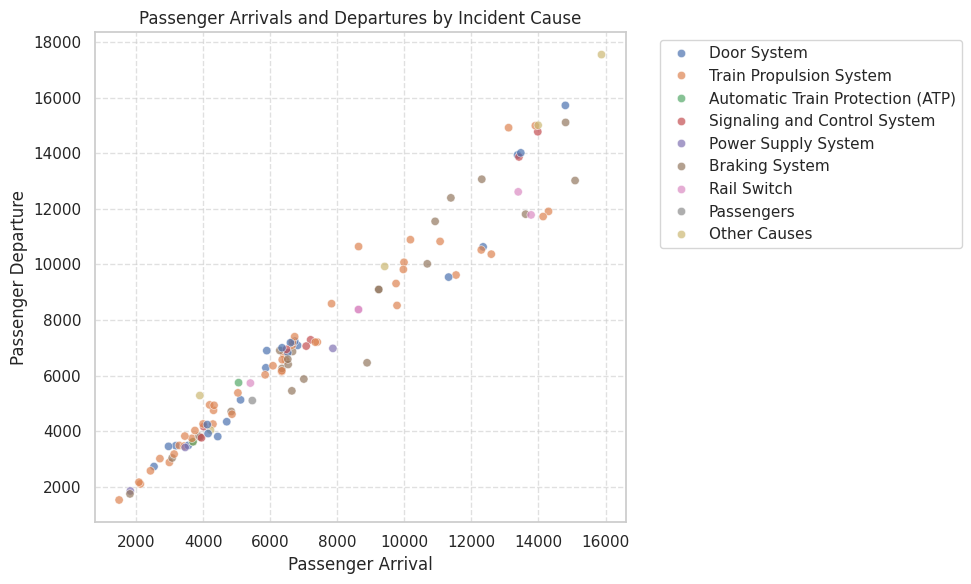

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=final_data,
    x='Passenger_Arrival',
    y='Passenger_Departure',
    hue='CAUSE_NAME',
    alpha=0.7
)
plt.title('Passenger Arrivals and Departures by Incident Cause')
plt.xlabel('Passenger Arrival')
plt.ylabel('Passenger Departure')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## **Clustering Analysis**

> Three clustering approaches are applied and compared:

*   K-Prototypes (mixed numerical and categorical data)
*   K-Means with one-hot encoding
*   Agglomerative clustering with Gower distance

The optimal number of clusters is selected using the **Silhouette coefficient** computed on **Gower distance**.
Cluster profiles are then interpreted to reveal operational patterns and actionable insights.



In [25]:
# =========================================
# 0) Imports & Global Config
# =========================================
K_RANGE = range(2, 11)

# -------------------------
# Global config
# -------------------------
N_CLUSTERS   = 6
RANDOM_STATE = 42
N_INIT_KP    = 30
INIT_METHOD_KP = "Huang"
RUN_ELBOW    = True


# =========================================
# 1) Input data
# =========================================
df = final_data.copy()

print("[INFO] Data shape:", df.shape)

# =========================================
# 2) Feature selection (numeric + categorical)
# =========================================
num_candidates = ["Passenger_Arrival", "Passenger_Departure"]
cat_candidates = [
    "ST1_ID",
    ("CAUSE_NAME" if "CAUSE_NAME" in df.columns else "CAUSE_ID"),
    "TIME_CATEGORY",
    "is_holiday", "is_weekend",
    "is_connect_bts", "is_connect_pier",
    "is_connect_mrt", "is_connect_yl", "is_connect_airport",
]

num_cols = [c for c in num_candidates if c in df.columns]
cat_cols = [c for c in cat_candidates if c in df.columns]

if not num_cols and not cat_cols:
    raise ValueError(
        "No features found. Please ensure numeric/categorical columns exist."
    )

print("[INFO] Numeric cols     :", num_cols)
print("[INFO] Categorical cols :", cat_cols)


# =========================================
# 3) Prepare data for K-Prototypes & Gower
# =========================================

# 3.1 Numeric for K-Prototypes (scaled)
if num_cols:
    scaler_kp = StandardScaler()
    Xnum_kp = pd.DataFrame(
        scaler_kp.fit_transform(df[num_cols]),
        columns=num_cols,
        index=df.index,
    )
else:
    warnings.warn(
        "No numeric columns found; K-Prototypes will use categorical only."
    )
    Xnum_kp = pd.DataFrame(index=df.index)

# 3.2 Categorical for K-Prototypes (as string)
if cat_cols:
    Xcat_kp = df[cat_cols].astype(str)
else:
    warnings.warn(
        "No categorical columns found; K-Prototypes normally expects some categorical features."
    )
    Xcat_kp = pd.DataFrame(index=df.index)

# 3.3 Combine numeric + categorical for K-Prototypes
cols_kp = num_cols + cat_cols
Xdf_kp = pd.concat([Xnum_kp, Xcat_kp], axis=1)
X_kp = Xdf_kp.to_numpy(dtype=object)

# index ของคอลัมน์ที่เป็น categorical ใน X_kp
cat_idx = [cols_kp.index(c) for c in cat_cols]

# 3.4 Data สำหรับ Gower (ใช้ค่าดิบ numeric + cat เป็น string)
Xdf_gower = df[num_cols + cat_cols].copy()
if cat_cols:
    Xdf_gower[cat_cols] = Xdf_gower[cat_cols].astype(str)

print("\n[INFO] dtypes used for Gower:")
print(Xdf_gower.dtypes)

print("\n[STEP] Computing Gower distance matrix ...")
D = gower.gower_matrix(Xdf_gower)   # NxN distance matrix
print("[OK] Gower matrix shape:", D.shape)


# =========================================
# 4) Agglomerative (hierarchical) + Gower distance
# =========================================
print("\n[STEP] Agglomerative clustering (hierarchical) + Gower distance")

try:
    agg = AgglomerativeClustering(
        n_clusters=N_CLUSTERS,
        metric="precomputed",
        linkage="average",
    )
    labels_hier = agg.fit_predict(D)
except TypeError:
    agg = AgglomerativeClustering(
        n_clusters=N_CLUSTERS,
        affinity="precomputed",
        linkage="average",
    )
    labels_hier = agg.fit_predict(D)

df_hier = df.copy()
df_hier["cluster_hier_gower"] = labels_hier.astype(int)

print("[Result] Agglomerative (Gower) cluster sizes:")
print(df_hier["cluster_hier_gower"].value_counts().sort_index())


# =========================================
# 5) K-Prototypes clustering (main method)
# =========================================
print("\n[STEP] K-Prototypes clustering")

kproto = KPrototypes(
    n_clusters=N_CLUSTERS,
    init=INIT_METHOD_KP,
    n_init=N_INIT_KP,
    random_state=RANDOM_STATE,
    verbose=0,
)

labels_kp = kproto.fit_predict(X_kp, categorical=cat_idx)

df_kp = df.copy()
df_kp["cluster_kproto"] = pd.Series(labels_kp, index=df.index).astype(int)

gamma_used = getattr(kproto, "gamma", None)
print(
    f"[OK] KPrototypes(k={N_CLUSTERS}, init='{INIT_METHOD_KP}', "
    f"gamma={gamma_used if gamma_used is not None else 'auto'})"
)
print("[Result] K-Prototypes cluster sizes:")
print(df_kp["cluster_kproto"].value_counts().sort_index())


# =========================================
# 6) K-Means baseline (numeric + one-hot categorical)
# =========================================
print("\n[STEP] K-Means baseline (numeric + one-hot categorical)")

df_km_in = df[num_cols + cat_cols].copy()
if cat_cols:
    df_km_in[cat_cols] = df_km_in[cat_cols].astype(str)

# one-hot encoding สำหรับ categorical columns
X_km = pd.get_dummies(df_km_in, columns=cat_cols, drop_first=False)

# scale เฉพาะ numeric columns
if num_cols:
    scaler_km = StandardScaler()
    X_km[num_cols] = scaler_km.fit_transform(X_km[num_cols])

kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    random_state=RANDOM_STATE,
    n_init=20,
)

labels_km = kmeans.fit_predict(X_km)

df_km = df.copy()
df_km["cluster_kmeans"] = labels_km.astype(int)

print("[Result] K-Means cluster sizes:")
print(df_km["cluster_kmeans"].value_counts().sort_index())


# =========================================
# 7) Helper: cluster profiling
# =========================================
def topn(s, n=3, decimals=0):
    """
    Return top-n values as 'Name (xx%)' joined string (percent within the cluster).
    """
    if s is None or s.empty:
        return None

    vc = s.value_counts(dropna=False)
    total = int(vc.sum())
    if total == 0:
        return None

    parts = [
        f"{k} ({(100.0 * v / total):.{decimals}f}%)"
        for k, v in vc.head(n).items()
    ]
    return ", ".join(parts)


def profile_clusters(df_in: pd.DataFrame, cluster_col: str) -> pd.DataFrame:
    """
    สร้างตารางสรุปโปรไฟล์ของแต่ละคลัสเตอร์:
    - ขนาดคลัสเตอร์
    - median arrival/departure
    - top ST1_ID / CAUSE / TIME_CATEGORY
    - สัดส่วน holiday / weekend / weekday
    """
    has_holiday = "is_holiday" in df_in.columns
    has_weekend = "is_weekend" in df_in.columns

    rows = []

    for cl in sorted(df_in[cluster_col].dropna().unique()):
        sub = df_in[df_in[cluster_col] == cl]

        holiday_rate = sub["is_holiday"].mean() if has_holiday else None
        weekend_rate = sub["is_weekend"].mean() if has_weekend else None

        weekday_rate = None
        if has_holiday and has_weekend:
            holiday_rate = holiday_rate or 0.0
            weekend_rate = weekend_rate or 0.0
            weekday_rate = 1.0 - holiday_rate - weekend_rate

        rows.append({
            "cluster": cl,
            "n": len(sub),
            "Arrival_med": sub["Passenger_Arrival"].median()
                            if "Passenger_Arrival" in sub.columns else None,
            "Depart_med": sub["Passenger_Departure"].median()
                            if "Passenger_Departure" in sub.columns else None,
            "ST1_top": topn(sub["ST1_ID"], n=3, decimals=0)
                        if "ST1_ID" in sub.columns else None,
            "CAUSE_top": topn(
                sub["CAUSE_NAME"] if "CAUSE_NAME" in sub.columns else sub["CAUSE_ID"],
                n=3, decimals=0,
            ) if ("CAUSE_NAME" in sub.columns or "CAUSE_ID" in sub.columns) else None,
            "TIME_top": topn(sub["TIME_CATEGORY"], n=3, decimals=0)
                        if "TIME_CATEGORY" in sub.columns else None,
            "Holiday_rate": holiday_rate,
            "Weekend_rate": weekend_rate,
            "Weekday_rate": weekday_rate,
        })

    return (
        pd.DataFrame(rows)
        .sort_values("cluster")
        .reset_index(drop=True)
    )

print("\n" + "="*60)
print("[Summary] K-Prototypes cluster profiles")
summary_kp = profile_clusters(df_kp, "cluster_kproto")
print(summary_kp.to_string(index=False))

print("\n" + "="*60)
print("[Summary] Agglomerative + Gower cluster profiles")
summary_hier = profile_clusters(df_hier, "cluster_hier_gower")
print(summary_hier.to_string(index=False))

print("\n" + "="*60)
print("[Summary] K-Means cluster profiles")
summary_km = profile_clusters(df_km, "cluster_kmeans")
print(summary_km.to_string(index=False))


# =========================================
# 8) Joint search over k (all methods) and gamma (K-Prototypes)
# =========================================
print("\n" + "="*60)
print("[STEP] Joint search for optimal k (all methods) and gamma (K-Prototypes)")

from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering, KMeans

K_RANGE = range(2, 11)            # k = 2..10
GAMMA_VALUES = [0.5, 1, 2, 5, 10] # for K-Prototypes

best_k = {"kproto": None, "hier": None, "kmeans": None}
best_sil = {"kproto": -1.0, "hier": -1.0, "kmeans": -1.0}
best_labels = {"kproto": None, "hier": None, "kmeans": None}
best_gamma = None

# เก็บผลไว้ใช้ plot ทีหลังได้
results_kproto = []   # list of dicts: {"k":k, "gamma":g, "sil":sil}
results_hier = []     # list of dicts: {"k":k, "sil":sil}
results_kmeans = []   # list of dicts: {"k":k, "sil":sil}

# 8.1 K-Prototypes: grid search over (k, gamma)
print("\n[Search] K-Prototypes (k, gamma)")

for k in K_RANGE:
    for g in GAMMA_VALUES:
        try:
            kp_tmp = KPrototypes(
                n_clusters=k,
                init=INIT_METHOD_KP,
                n_init=N_INIT_KP,
                random_state=RANDOM_STATE,
                gamma=g,
                verbose=0,
            )
            labels_tmp = kp_tmp.fit_predict(X_kp, categorical=cat_idx)
            sil_tmp = silhouette_score(D, labels_tmp, metric="precomputed")
            results_kproto.append({"k": k, "gamma": g, "sil": sil_tmp})

            print(f"  k={k:2d}, γ={g:4.1f}, Silhouette={sil_tmp:.3f}")

            if sil_tmp > best_sil["kproto"]:
                best_sil["kproto"] = sil_tmp
                best_k["kproto"] = k
                best_gamma = g
                best_labels["kproto"] = labels_tmp
        except ValueError as e:
            print(f"  k={k:2d}, γ={g:4.1f} SKIPPED -> {e}")
            continue

print(f"\n[RESULT] Best K-Prototypes: k = {best_k['kproto']}, "
      f"gamma = {best_gamma}, Silhouette = {best_sil['kproto']:.3f}")


# 8.2 Agglomerative (Gower): search over k only
print("\n[Search] Agglomerative (Gower) over k")

for k in K_RANGE:
    try:
        hier = AgglomerativeClustering(
            n_clusters=k,
            linkage="average",
            metric="precomputed"
        )
        labels_tmp = hier.fit_predict(D)
        sil_tmp = silhouette_score(D, labels_tmp, metric="precomputed")
        results_hier.append({"k": k, "sil": sil_tmp})

        print(f"  k={k:2d}, Silhouette={sil_tmp:.3f}")

        if sil_tmp > best_sil["hier"]:
            best_sil["hier"] = sil_tmp
            best_k["hier"] = k
            best_labels["hier"] = labels_tmp
    except ValueError as e:
        print(f"  k={k:2d} SKIPPED -> {e}")
        continue

print(f"\n[RESULT] Best Agglomerative (Gower): k = {best_k['hier']}, "
      f"Silhouette = {best_sil['hier']:.3f}")


# 8.3 K-Means: search over k only
print("\n[Search] K-Means over k")

for k in K_RANGE:
    try:
        km = KMeans(
            n_clusters=k,
            n_init=20,
            random_state=RANDOM_STATE,
        )
        labels_tmp = km.fit_predict(X_km)  # X_km = standardized numeric + one-hot categorical

        # Evaluate K-Means cluster quality using Gower distance (for fair comparison across models)
        sil_tmp = silhouette_score(D, labels_tmp, metric="precomputed")

        results_kmeans.append({"k": k, "sil": sil_tmp})

        print(f"  k={k:2d}, Silhouette={sil_tmp:.3f}")

        if sil_tmp > best_sil["kmeans"]:
            best_sil["kmeans"] = sil_tmp
            best_k["kmeans"] = k
            best_labels["kmeans"] = labels_tmp
    except ValueError as e:
        print(f"  k={k:2d} SKIPPED -> {e}")
        continue

print(f"\n[RESULT] Best K-Means: k = {best_k['kmeans']}, "
      f"Silhouette = {best_sil['kmeans']:.3f}")


[INFO] Data shape: (113, 29)
[INFO] Numeric cols     : ['Passenger_Arrival', 'Passenger_Departure']
[INFO] Categorical cols : ['ST1_ID', 'CAUSE_NAME', 'TIME_CATEGORY', 'is_holiday', 'is_weekend', 'is_connect_bts', 'is_connect_pier', 'is_connect_mrt', 'is_connect_yl', 'is_connect_airport']

[INFO] dtypes used for Gower:
Passenger_Arrival      float64
Passenger_Departure    float64
ST1_ID                  object
CAUSE_NAME              object
TIME_CATEGORY           object
is_holiday              object
is_weekend              object
is_connect_bts          object
is_connect_pier         object
is_connect_mrt          object
is_connect_yl           object
is_connect_airport      object
dtype: object

[STEP] Computing Gower distance matrix ...
[OK] Gower matrix shape: (113, 113)

[STEP] Agglomerative clustering (hierarchical) + Gower distance
[Result] Agglomerative (Gower) cluster sizes:
cluster_hier_gower
0    34
1    12
2    17
3    10
4    19
5    21
Name: count, dtype: int64

[STEP] K

#### Final profiles using best k (and gamma for K-Prototypes)

In [26]:
# =========================================
# 9) Final profiles using best k (and gamma for K-Prototypes)
# =========================================

# 9.1 K-Prototypes best
df_kp_best = df.copy()
df_kp_best["cluster_kproto"] = pd.Series(
    best_labels["kproto"], index=df.index
).astype(int)
summary_kp_best = profile_clusters(df_kp_best, "cluster_kproto")

# 9.2 Agglomerative best
# df_hier_best = df.copy()
# df_hier_best["cluster_hier_gower"] = pd.Series(
#     best_labels["hier"], index=df.index
# ).astype(int)
# summary_hier_best = profile_clusters(df_hier_best, "cluster_hier_gower")

# 9.3 K-Means best
# df_km_best = df.copy()
# df_km_best["cluster_kmeans"] = pd.Series(
#     best_labels["kmeans"], index=df.index
# ).astype(int)
# summary_km_best = profile_clusters(df_km_best, "cluster_kmeans")

print("\n[Summary] K-Prototypes (best k & gamma) cluster profiles")
print(summary_kp_best.to_string(index=False))

# print("\n[Summary] Agglomerative + Gower (best k) cluster profiles")
# print(summary_hier_best.to_string(index=False))

# print("\n[Summary] K-Means (best k) cluster profiles")
# print(summary_km_best.to_string(index=False))



[Summary] K-Prototypes (best k & gamma) cluster profiles
 cluster  n  Arrival_med  Depart_med            ST1_top                                                                               CAUSE_top                                                TIME_top  Holiday_rate  Weekend_rate  Weekday_rate
       0 19       5852.0      6027.0          A5 (100%)                   Train Propulsion System (53%), Door System (32%), Braking System (5%)     evening peak (32%), night (26%), morning peak (21%)      0.000000      0.105263      0.894737
       1 21       6349.0      6257.0          A4 (100%) Train Propulsion System (48%), Braking System (19%), Signaling and Control System (10%) off-peak (43%), evening peak (33%), early morning (14%)      0.000000      0.095238      0.904762
       2 12      13385.5     13500.0          A8 (100%)                             Door System (25%), Other Causes (25%), Braking System (25%)         evening peak (33%), night (25%), off-peak (17%)      0.000000   